# ▶️ Initial Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
ROOT_DIR = "data/osha/"

In [3]:
import os, sys
sys.path.append("src/")
sys.path.append("../src/")

In [4]:
# Import modules for LLM finetuning and evaluation
import finetune as ft
import evaluate as ev

In [6]:
import model_prompts as prompts
from evaluate import EvaluationConfig

def evaluate_model(configurations, model, tokenizer, label_names, eval_dataset):
    results = []
    for config in configurations:
        result = ev.evaluate(
            model=model, tokenizer=tokenizer, label_names=label_names,
            eval_dataset=dataset['test'], eval_config=config
        )
        results.append(result)
    return results

def save_results(results):
    for result in results:
        result.save(os.path.join(ROOT_DIR, "results/multi-class")) # Saves to "data/osha/results/<EvaluationConfig.name>"

# ▶️ Load and Preprocess OSHA Injuries dataset

In [7]:
import pandas as pd

data = pd.read_csv(
    os.path.join(ROOT_DIR, "datasets/January2015toJuly2024.csv"),
    low_memory=False)

In [8]:
input_features = ["Final Narrative", "EventTitle"]
output_labels = ["NatureTitle", "Part of Body Title"]

In [ ]:
# Convert DataFrame into a Dataset
dataset = ft.create_dataset_from_dataframe(data, input_features, output_labels)

In [ ]:
# Select items from the 10 most common classes
dataset = ft.select_top_n_classes(dataset, n=10, label_columns=output_labels)

In [11]:
# Reduce the size of the dataset for testing purposes
dataset['train'] = dataset['train'].shard(5, 0) # First 20% of the train dataset
dataset['test'] = dataset['test'].shard(10, 0) # First 10% of the test dataset

In [ ]:
# Preprocess the dataset into a form usable for supervised finetuning
dataset, label_names = ft.preprocess_dataset(dataset,text_columns=input_features,label_columns=output_labels)

# ▶️ Load Baseline LLM

NOTE: I want to refactor this into one function -> ``ft.load_model(name, device_map, quantized)``

I think it would be a bit nicer.

In [16]:
MODEL_ID = "Qwen/Qwen2.5-7B-Instruct"
MODEL_DEVICE = "cuda:0"
QUANTIZED = True # Load model with 4-bit quantization

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# Same quantization configuration as QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.float16
) if QUANTIZED else None

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map=MODEL_DEVICE,
    use_cache=False # use_cache is incompatible with gradient checkpointing
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

# ▶️ Evaluate Baseline LLM

In [18]:
# Configurations for the baseline LLM
baseline_configurations = [
    EvaluationConfig(
        name="Zero-shot Multi-task",
        prompt=prompts.OSHA["MULTI_TASK"],
        max_tokens=40
    )
]

In [ ]:
baseline_results = evaluate_model(baseline_configurations, model=model, tokenizer=tokenizer, label_names=label_names, eval_dataset=dataset['test'])

In [ ]:
save_results(baseline_results)

# ▶️ Finetune LLM

In [21]:
FINETUNED_LLM_PATH = os.path.join(ROOT_DIR, "models/Qwen2.5-FT-OSHA-Injuries-Multiclass-2")

LORA_RANK_DIMENSION = 6 # the rank of the adapter, the lower the fewer parameters you'll need to train. (smaller = more compression)
LORA_ALPHA = 8 # this is the scaling factor for LoRA layers (higher = stronger adaptation)
LORA_DROPOUT = 0.05 # dropout probability for LoRA layers (helps prevent overfitting)
MAX_SEQ_LENGTH = 64
EPOCHS=1
LEARNING_RATE=2e-4

In [22]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=LORA_RANK_DIMENSION,
    lora_alpha=LORA_ALPHA,
    bias="none",
    lora_dropout=LORA_DROPOUT,
    task_type="CAUSAL_LM"
)

In [23]:
from trl import SFTConfig, SFTTrainer

sft_config = SFTConfig(
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant': False},
    gradient_accumulation_steps=1,
    per_device_train_batch_size=16,
    auto_find_batch_size=True,
    
    max_seq_length=MAX_SEQ_LENGTH,
    packing=True,
    
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optim='adamw_torch_fused',
    warmup_ratio=0.03,
    lr_scheduler_type="constant", 
    
    logging_steps=10,
    logging_dir='./logs',
    output_dir=FINETUNED_LLM_PATH,
    report_to='none'
)

In [ ]:
history = ft.finetune( # Will save the model to the directory: FINETUNED_LLM_PATH
    model=model, tokenizer=tokenizer,
    train_dataset=dataset['train'],
    lora_config=lora_config, sft_config=sft_config
)

In [ ]:
history.to_csv(os.path.join(ROOT_DIR, "results/multi-class/loss_history.csv"), index=False) # Save the training history

Text(0.5, 1.0, 'Fine-tuning Training History')

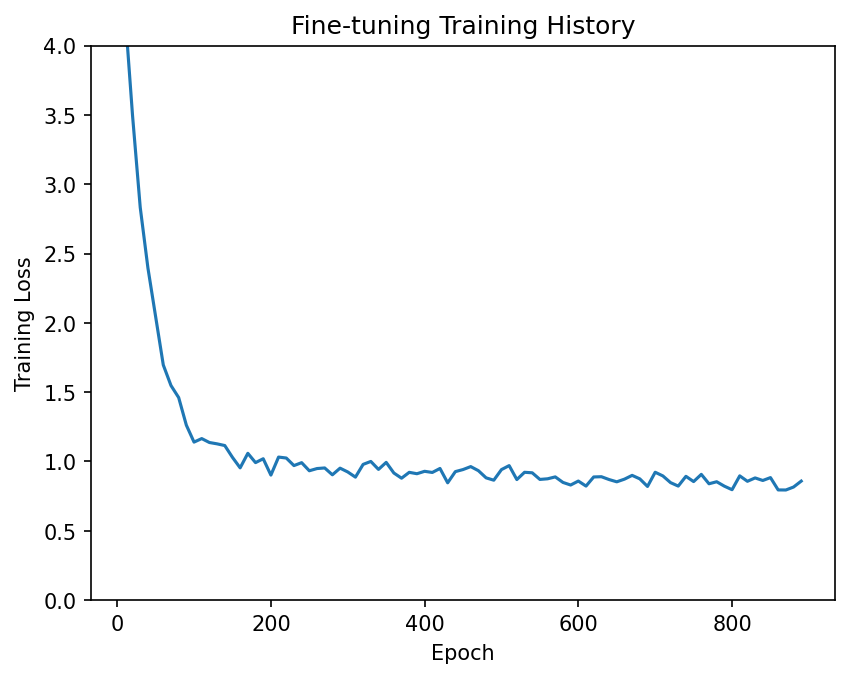

In [58]:
# Plot the training history and save the plot
import math
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 150
plt.plot(history.set_index("Step"))
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

loss_max = math.ceil(history['Training Loss'].max())
plt.ylim([0, loss_max])

plt.title("Fine-tuning Training History")

path = os.path.join(ROOT_DIR, "results/multi-class/loss_history.png")
plt.savefig( path, dpi=200, bbox_inches='tight' )

# ▶️ Load Finetuned LLM

In [25]:
# Unload the baseline model if it exists, otherwise we will probably get an OOM exception
import gc, torch

if "bnb_config" in locals(): del bnb_config
if "tokenizer" in locals(): del tokenizer
if "model" in locals(): del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
FINETUNED_LLM_PATH = os.path.join(ROOT_DIR, "models/Qwen2.5-FT-OSHA-Injuries-Multiclass-2")
MODEL_DEVICE = "cuda:0"
QUANTIZED = True # Load model with 4-bit quantization

model, tokenizer = ft.load_finetuned_llm(FINETUNED_LLM_PATH, MODEL_DEVICE, QUANTIZED)

# ▶️ Evaluate Finetuned LLM

In [27]:
finetuned_configurations = [
    EvaluationConfig(
        name="Fine-tuned Multi-task",
        prompt=None,
        max_tokens=40
    )
]

In [ ]:
finetuned_results = evaluate_model(finetuned_configurations, model=model, tokenizer=tokenizer, label_names=label_names, eval_dataset=dataset['test'])

In [ ]:
save_results(finetuned_results)